In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../tensiometer/')))
import tensiometer

import getdist
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import GaussianND

# Make parameter difference chain and gaussian approx

In [3]:
# load the samples (remove no burn in since the example chains have already been cleaned):
chains_dir = '../tensiometer/test_chains/'
# the Planck 2018 TTTEEE chain:
chain_1 = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'Planck18TTTEEE', no_cache=True)
# the DES Y1 3x2 chain:
chain_2 = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'DES', no_cache=True)
# the joint chain:
chain_12 = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'Planck18TTTEEE_DES', no_cache=True)
# the prior chain:
prior_chain = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'prior', no_cache=True)

In [4]:
from tensiometer import mcmc_tension
# get the parameter difference chain:
diff_chain = mcmc_tension.parameter_diff_chain( chain_1, chain_2, boost=4 )

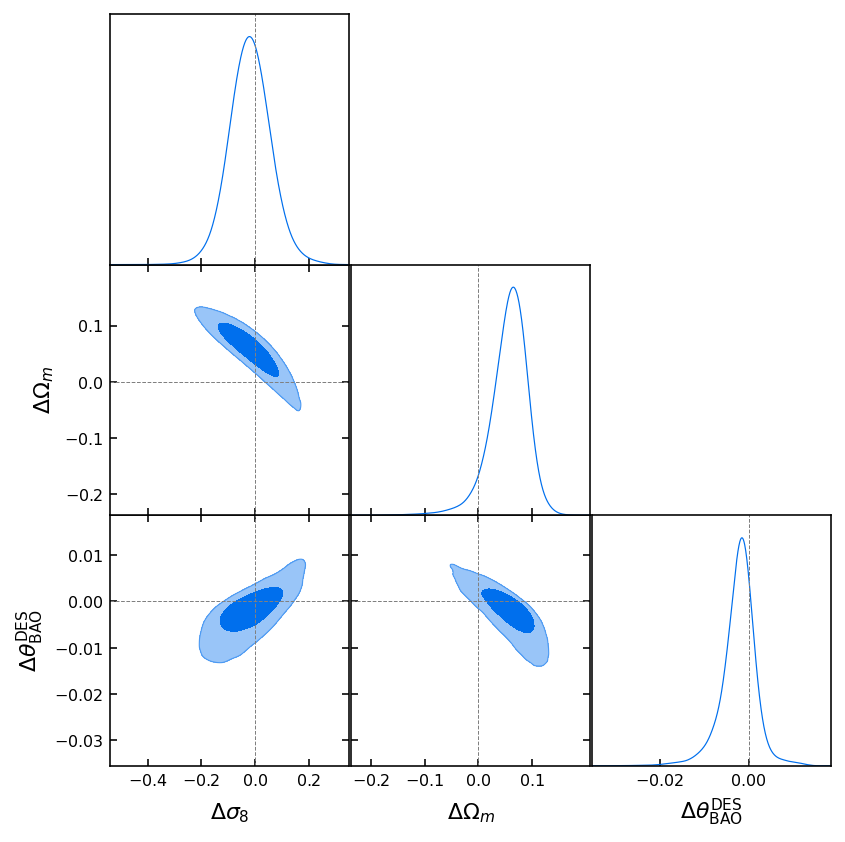

In [5]:
g = plots.get_subplot_plotter()
g.triangle_plot([diff_chain], params=['delta_sigma8','delta_omegam','delta_theta_BAO_DES'], filled=True, markers={'delta_sigma8':0,'delta_omegam':0,'delta_theta_BAO_DES':0})

In [6]:
param_names = diff_chain.getParamNames().getRunningNames()

In [7]:
gaussian_approx = tensiometer.gaussian_tension.gaussian_approximation(diff_chain)

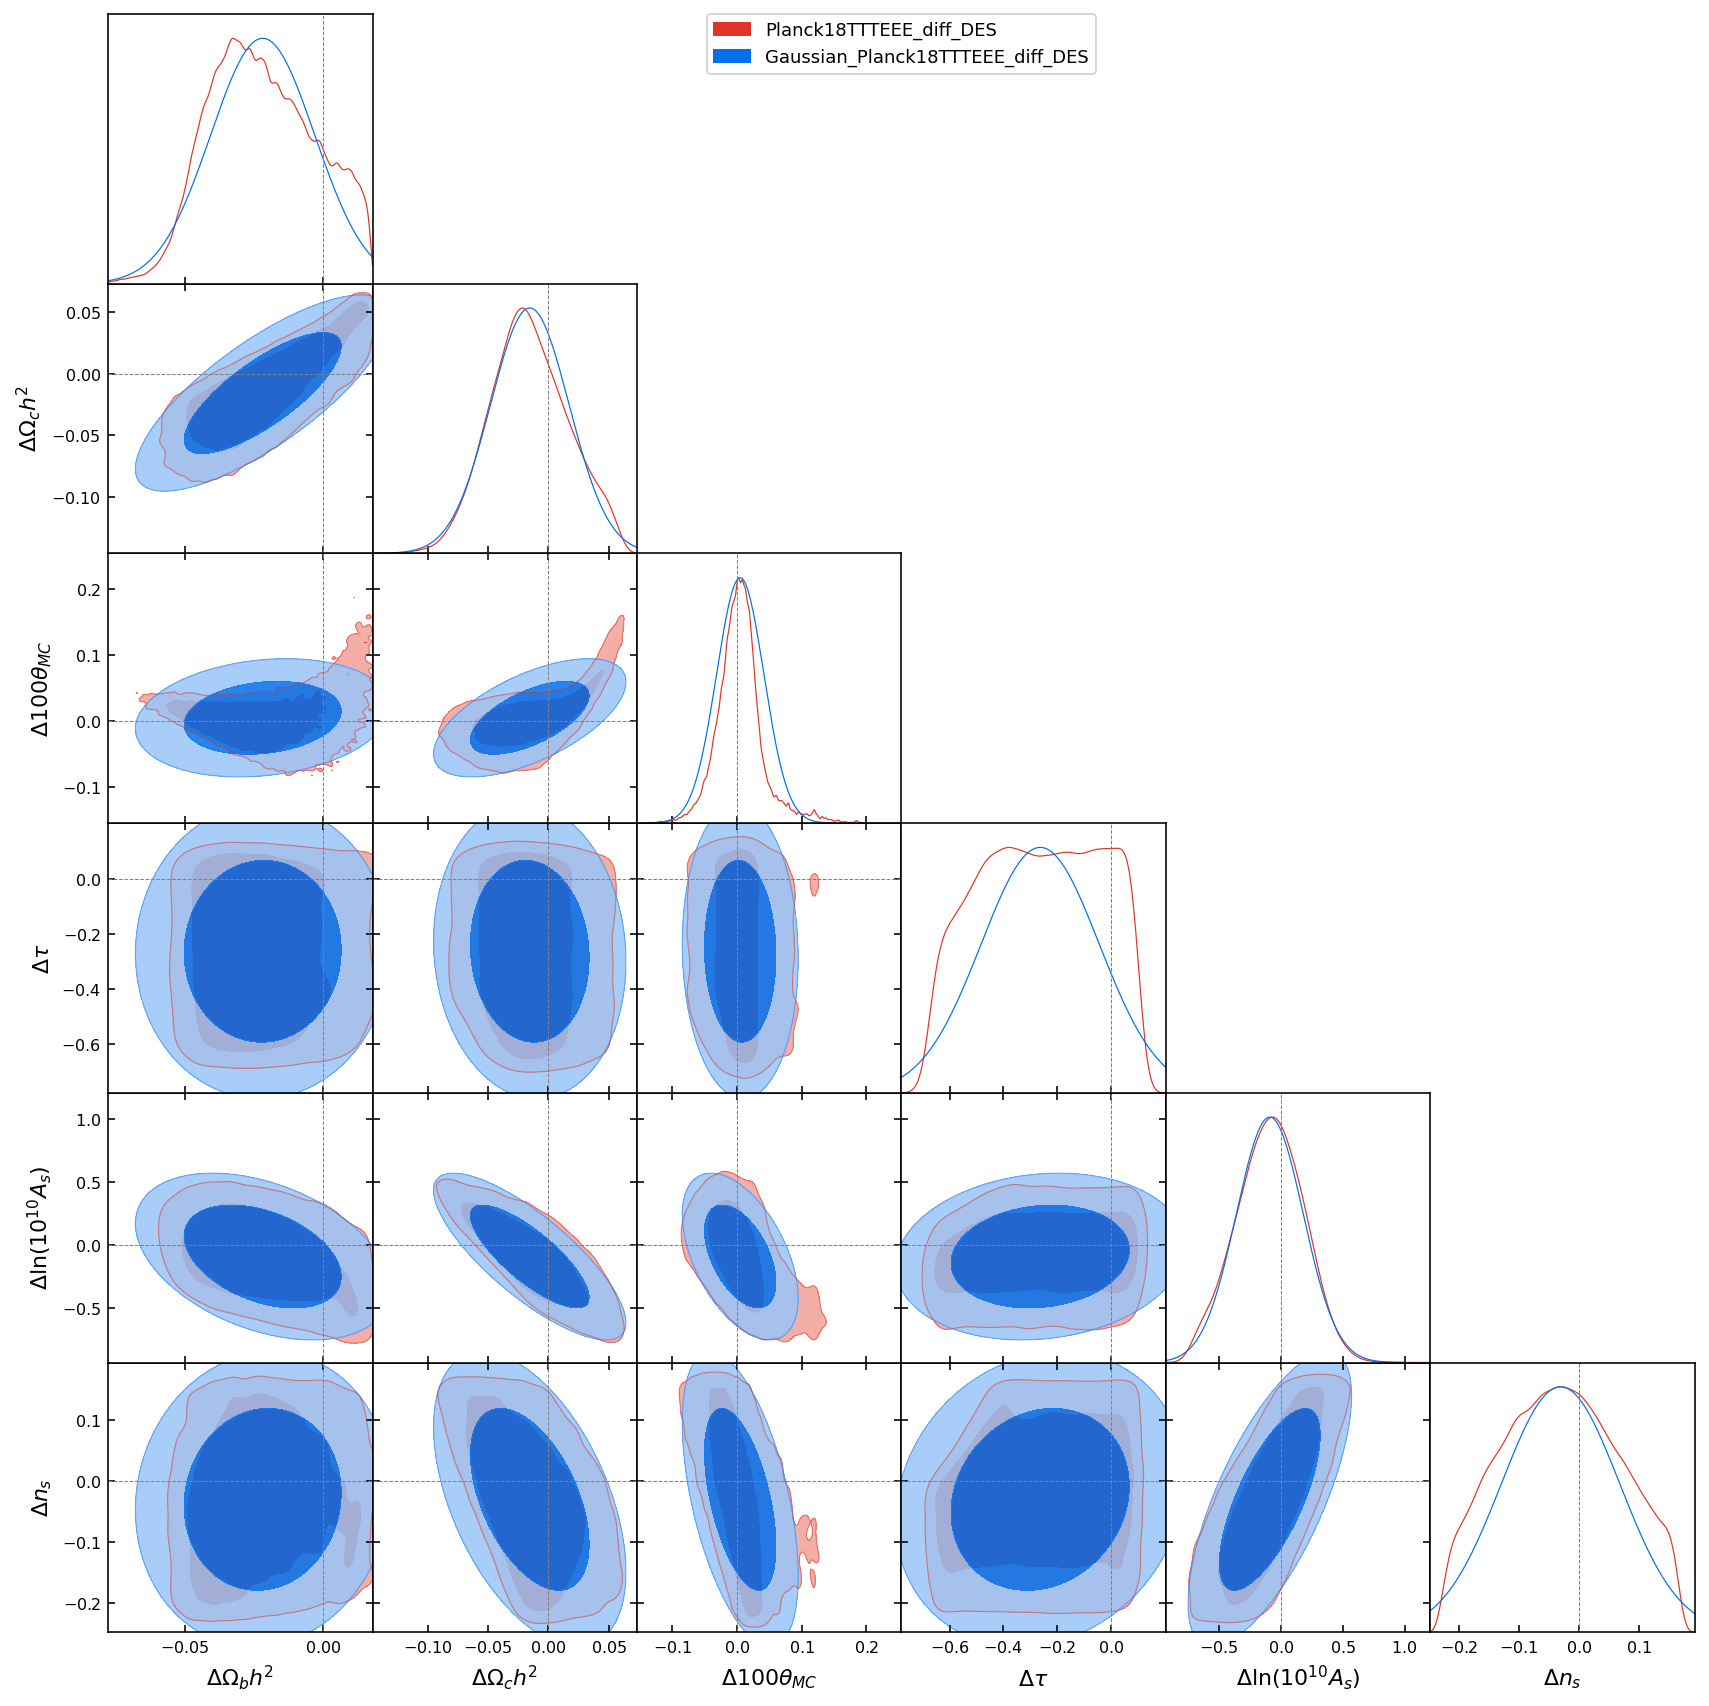

In [8]:
g = plots.get_subplot_plotter()
g.triangle_plot([diff_chain, gaussian_approx], params=param_names, filled=True,
                markers={_p:0 for _p in param_names})

# Gaussianize parameter difference chain

In [15]:
diff_flow_callback = tensiometer.mcmc_tension.flow_parameter_shift(diff_chain, feedback=1)

Building MAF
    - trainable parameters: 4752
    - activation: <function leaky_relu at 0x7fa2d5edd170>
    - hidden_units: [12, 12]


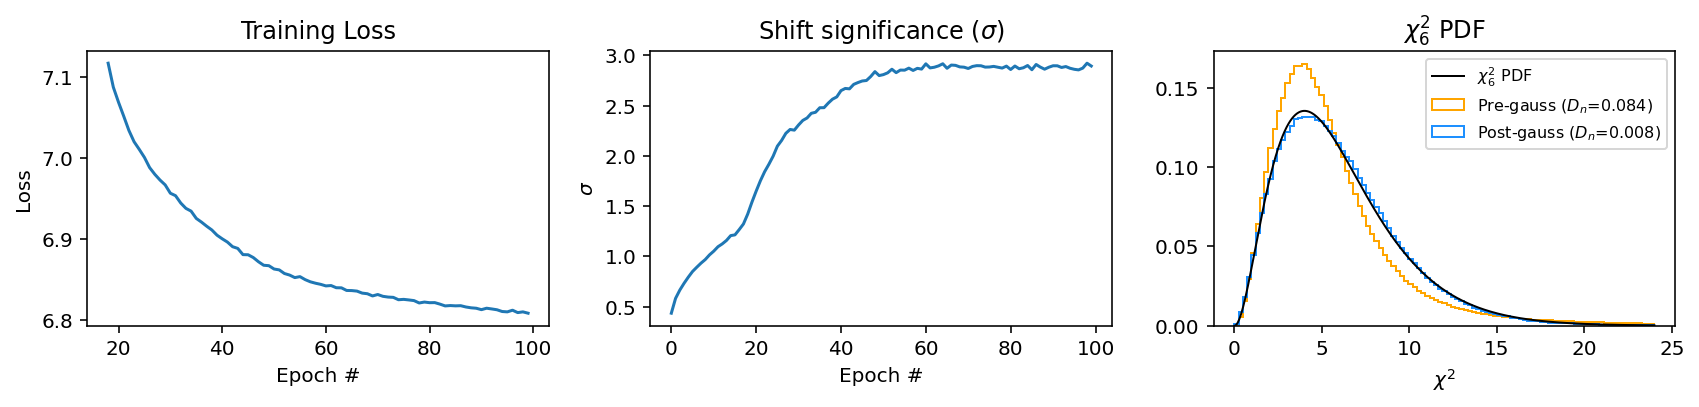

128/128 [==============================] - 13s 105ms/step - loss: 6.8083


In [16]:
batch_size = 8192
epochs = 100
steps_per_epoch = 128
callbacks = []

diff_flow_callback.train(batch_size=batch_size, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=callbacks)

In [17]:
diff_flow_callback.compute_shift_proba() # this is actually the significance of the proba...

2.89319622985353

# Plot learned distribution

In [23]:
N = 100000
Y_sample = np.array(diff_flow_callback.dist_transformed.sample(N))
X_sample = np.array(diff_flow_callback.Y2X_bijector.forward(Y_sample))

diff_flow = MCSamples(samples=X_sample, names=param_names, label='Learned distribution')

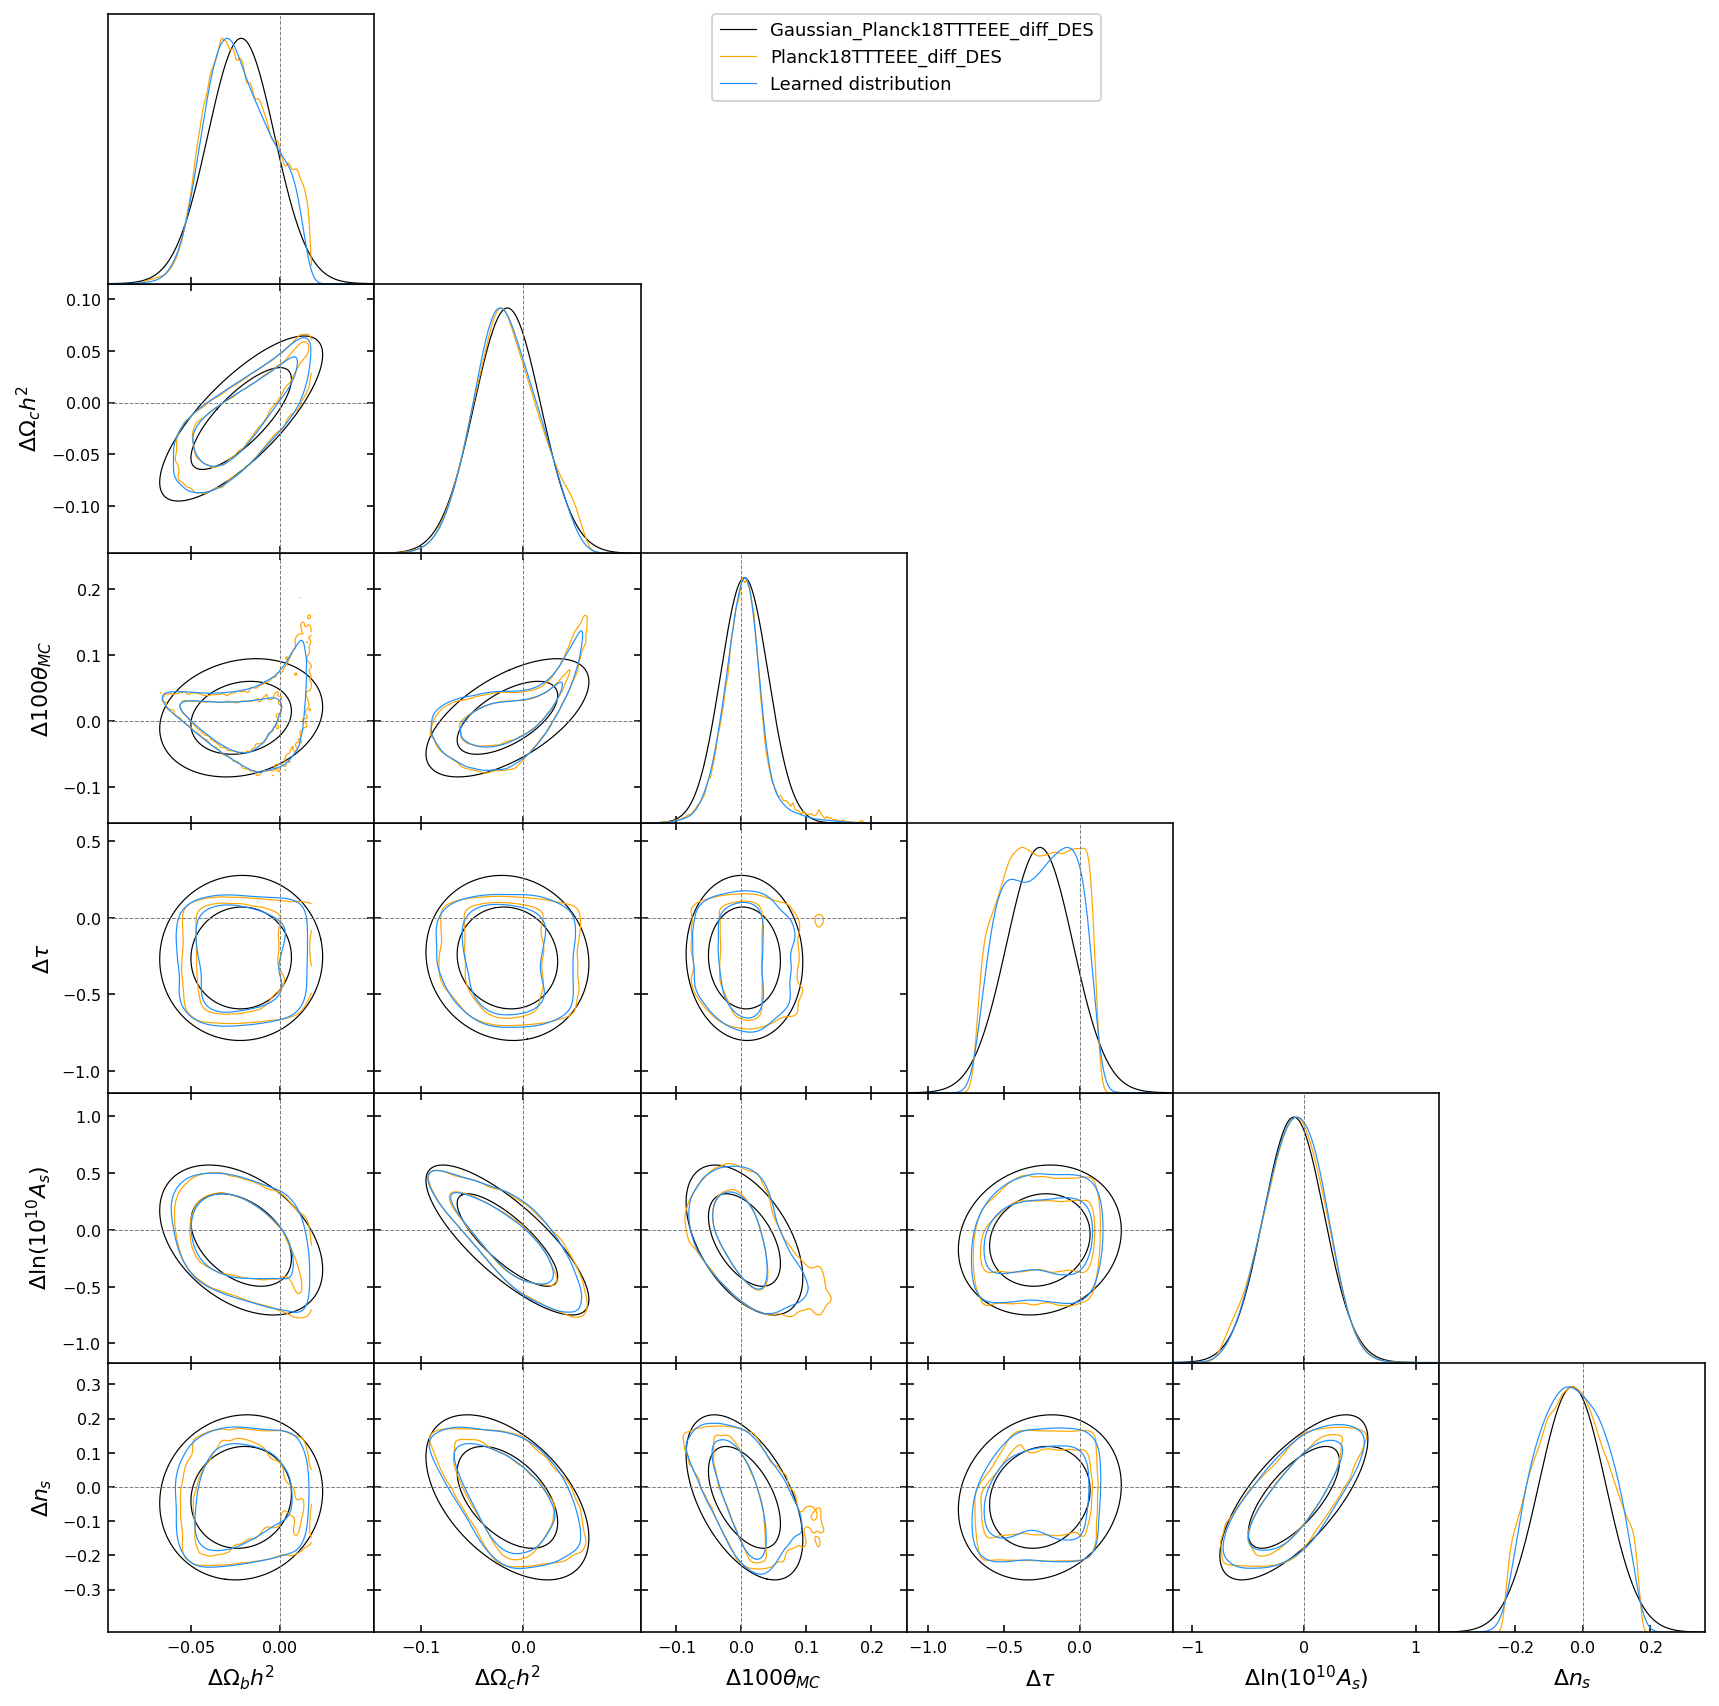

In [24]:
colors=['k', 'orange', 'dodgerblue']
g = plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot([gaussian_approx, diff_chain, diff_flow], params=param_names,
                filled=False, markers={_p:0 for _p in param_names},
                colors=colors, diag1d_kwargs={'colors':colors})